In [4]:
# ! wget "https://github.com/airalcorn2/pytorch-nerf/blob/master/66bdbc812bd0a196e194052f3f12cb2e.npz?raw=True" -O 66bdbc812bd0a196e194052f3f12cb2e.npz

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torch import nn, optim


def get_coarse_query_points(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os):
    # Sample depths (t_is_c). See Equation (2) in Section 4.
    u_is_c = torch.rand(*list(ds.shape[:2]) + [N_c]).to(ds)
    t_is_c = t_i_c_bin_edges + u_is_c * t_i_c_gap
    # Calculate the points along the rays (r_ts_c) using the ray origins (os), sampled
    # depths (t_is_c), and ray directions (ds). See Section 4: r(t) = o + t * d.
    r_ts_c = os[..., None, :] + t_is_c[..., :, None] * ds[..., None, :]
    return (r_ts_c, t_is_c)


def get_fine_query_points(w_is_c, N_f, t_is_c, t_f, os, ds):
    # See text surrounding Equation (5) in Section 5.2 and:
    # https://stephens999.github.io/fiveMinuteStats/inverse_transform_sampling.html#discrete_distributions.

    # Define PDFs (pdfs) and CDFs (cdfs) from weights (w_is_c).
    w_is_c = w_is_c + 1e-5
    pdfs = w_is_c / torch.sum(w_is_c, dim=-1, keepdim=True)
    cdfs = torch.cumsum(pdfs, dim=-1)
    cdfs = torch.cat([torch.zeros_like(cdfs[..., :1]), cdfs[..., :-1]], dim=-1)

    # Get uniform samples (us).
    us = torch.rand(list(cdfs.shape[:-1]) + [N_f]).to(w_is_c)

    # Use inverse inverse transform sampling to sample the depths (t_is_f).
    idxs = torch.searchsorted(cdfs, us, right=True)
    t_i_f_bottom_edges = torch.gather(t_is_c, 2, idxs - 1)
    idxs_capped = idxs.clone()
    max_ind = cdfs.shape[-1]
    idxs_capped[idxs_capped == max_ind] = max_ind - 1
    t_i_f_top_edges = torch.gather(t_is_c, 2, idxs_capped)
    t_i_f_top_edges[idxs == max_ind] = t_f
    t_i_f_gaps = t_i_f_top_edges - t_i_f_bottom_edges
    u_is_f = torch.rand_like(t_i_f_gaps).to(os)
    t_is_f = t_i_f_bottom_edges + u_is_f * t_i_f_gaps

    # Combine the coarse (t_is_c) and fine (t_is_f) depths and sort them.
    (t_is_f, _) = torch.sort(torch.cat([t_is_c, t_is_f.detach()], dim=-1), dim=-1)
    # Calculate the points along the rays (r_ts_f) using the ray origins (os), depths
    # (t_is_f), and ray directions (ds). See Section 4: r(t) = o + t * d.
    r_ts_f = os[..., None, :] + t_is_f[..., :, None] * ds[..., None, :]
    return (r_ts_f, t_is_f)

def render_radiance_volume(r_ts, ds, chunk_size, F, t_is):
    # Use the network (F) to predict colors (c_is) and volume densities (sigma_is) for
    # 3D points along rays (r_ts) given the viewing directions (ds) of the rays. See
    # Section 3 and Figure 7 in the Supplementary Materials.


    r_ts_flat = r_ts.reshape((-1, 3))
    ds_rep = ds.unsqueeze(2).repeat(1, 1, r_ts.shape[-2], 1)
    ds_flat = ds_rep.reshape((-1, 3))

    c_is = []
    sigma_is = []
    # The network processes batches of inputs to avoid running out of memory.
    for chunk_start in range(0, r_ts_flat.shape[0], chunk_size):
        r_ts_batch = r_ts_flat[chunk_start : chunk_start + chunk_size]
        ds_batch = ds_flat[chunk_start : chunk_start + chunk_size]
        preds = F(r_ts_batch, ds_batch)
        c_is.append(preds["c_is"])
        sigma_is.append(preds["sigma_is"])

    c_is = torch.cat(c_is).reshape(r_ts.shape)
    sigma_is = torch.cat(sigma_is).reshape(r_ts.shape[:-1])

    # Calculate the distances (delta_is) between points along the rays. The differences
    # in depths are scaled by the norms of the ray directions to get the final
    # distances. See text following Equation (3) in Section 4.
    delta_is = t_is[..., 1:] - t_is[..., :-1]
    # "Infinity". Guarantees last alpha is always one.
    one_e_10 = torch.Tensor([1e10]).expand(delta_is[..., :1].shape)
    delta_is = torch.cat([delta_is, one_e_10.to(delta_is)], dim=-1)
    delta_is = delta_is * ds.norm(dim=-1).unsqueeze(-1)

    # Calculate the alphas (alpha_is) of the 3D points using the volume densities
    # (sigma_is) and distances between points (delta_is). See text following Equation
    # (3) in Section 4 and https://en.wikipedia.org/wiki/Alpha_compositing.
    alpha_is = 1.0 - torch.exp(-sigma_is * delta_is)

    # Calculate the accumulated transmittances (T_is) along the rays from the alphas
    # (alpha_is). See Equation (3) in Section 4. T_i is "the probability that the ray
    # travels from t_n to t_i without hitting any other particle".
    T_is = torch.cumprod(1.0 - alpha_is + 1e-10, -1)
    # Guarantees the ray makes it at least to the first step. See:
    # https://github.com/bmild/nerf/blob/18b8aebda6700ed659cb27a0c348b737a5f6ab60/run_nerf.py#L142,
    # which uses tf.math.cumprod(1.-alpha + 1e-10, axis=-1, exclusive=True).
    T_is = torch.roll(T_is, 1, -1)
    T_is[..., 0] = 1.0

    # Calculate the weights (w_is) for the colors (c_is) along the rays using the
    # transmittances (T_is) and alphas (alpha_is). See Equation (5) in Section 5.2:
    # w_i = T_i * (1 - exp(-sigma_i * delta_i)).
    w_is = T_is * alpha_is

    # Calculate the pixel colors (C_rs) for the rays as weighted (w_is) sums of colors
    # (c_is). See Equation (5) in Section 5.2: C_c_hat(r) = Σ w_i * c_i.
    C_rs = (w_is[..., None] * c_is).sum(dim=-2)

    return (C_rs, w_is)




def run_one_iter_of_nerf(
     ds, N_c, t_i_c_bin_edges, t_i_c_gap, os, chunk_size, F_c, N_f, t_f, F_f
 ):
     (r_ts_c, t_is_c) = get_coarse_query_points(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os)

     (C_rs_c, w_is_c) = render_radiance_volume(r_ts_c, ds, chunk_size, F_c, t_is_c)

     (r_ts_f, t_is_f) = get_fine_query_points(w_is_c, N_f, t_is_c, t_f, os, ds)
     (C_rs_f, _) = render_radiance_volume(r_ts_f, ds, chunk_size, F_f, t_is_f)

     return (C_rs_c, C_rs_f)


class NeRFMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Number of encoding functions for positions. See Section 5.1.
        self.L_pos = 10
        # Number of encoding functions for viewing directions. See Section 5.1.
        self.L_dir = 4
        pos_enc_feats = 3 + 3 * 2 * self.L_pos
        dir_enc_feats = 3 + 3 * 2 * self.L_dir

        in_feats = pos_enc_feats
        net_width = 256
        early_mlp_layers = 5
        early_mlp = []
        for layer_idx in range(early_mlp_layers):
            early_mlp.append(nn.Linear(in_feats, net_width))
            early_mlp.append(nn.ReLU())
            in_feats = net_width

        self.early_mlp = nn.Sequential(*early_mlp)

        in_feats = pos_enc_feats + net_width
        late_mlp_layers = 3
        late_mlp = []
        for layer_idx in range(late_mlp_layers):
            late_mlp.append(nn.Linear(in_feats, net_width))
            late_mlp.append(nn.ReLU())
            in_feats = net_width

        self.late_mlp = nn.Sequential(*late_mlp)
        self.sigma_layer = nn.Linear(net_width, net_width + 1)
        self.pre_final_layer = nn.Sequential(
            nn.Linear(dir_enc_feats + net_width, net_width // 2), nn.ReLU()
        )
        self.final_layer = nn.Sequential(nn.Linear(net_width // 2, 3), nn.Sigmoid())

    def forward(self, xs, ds):
        # Encode the inputs. See Equation (4) in Section 5.1.
        xs_encoded = [xs]
        for l_pos in range(self.L_pos):
            xs_encoded.append(torch.sin(2 ** l_pos * torch.pi * xs))
            xs_encoded.append(torch.cos(2 ** l_pos * torch.pi * xs))

        xs_encoded = torch.cat(xs_encoded, dim=-1)

        ds = ds / ds.norm(p=2, dim=-1).unsqueeze(-1)
        ds_encoded = [ds]
        for l_dir in range(self.L_dir):
            ds_encoded.append(torch.sin(2 ** l_dir * torch.pi * ds))
            ds_encoded.append(torch.cos(2 ** l_dir * torch.pi * ds))

        ds_encoded = torch.cat(ds_encoded, dim=-1)

        # Use the network to predict colors (c_is) and volume densities (sigma_is) for
        # 3D points (xs) along rays given the viewing directions (ds) of the rays. See
        # Section 3 and Figure 7 in the Supplementary Materials.
        outputs = self.early_mlp(xs_encoded)
        outputs = self.late_mlp(torch.cat([xs_encoded, outputs], dim=-1))
        outputs = self.sigma_layer(outputs)
        sigma_is = torch.relu(outputs[:, 0])
        outputs = self.pre_final_layer(torch.cat([ds_encoded, outputs[:, 1:]], dim=-1))
        c_is = self.final_layer(outputs)
        return {"c_is": c_is, "sigma_is": sigma_is}

cuda:0


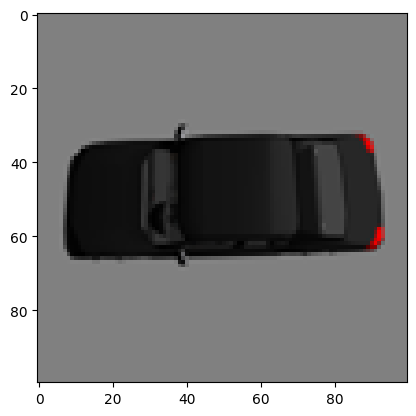

In [2]:
# Set seed.
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Initialize coarse and fine MLPs.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
F_c = NeRFMLP().to(device)
F_f = NeRFMLP().to(device)
# Number of query points passed through the MLP at a time. See: https://github.com/bmild/nerf/blob/18b8aebda6700ed659cb27a0c348b737a5f6ab60/run_nerf.py#L488.
chunk_size = 1024 * 32
# Number of training rays per iteration. See Section 5.3.
batch_img_size = 64
n_batch_pix = batch_img_size ** 2

# Initialize optimizer. See Section 5.3.
lr = 5e-4
optimizer = optim.Adam(list(F_c.parameters()) + list(F_f.parameters()), lr=lr)
criterion = nn.MSELoss()
# The learning rate decays exponentially. See Section 5.3
# See: https://github.com/bmild/nerf/blob/18b8aebda6700ed659cb27a0c348b737a5f6ab60/run_nerf.py#L486.
lrate_decay = 250
decay_steps = lrate_decay * 1000
# See: https://github.com/bmild/nerf/blob/18b8aebda6700ed659cb27a0c348b737a5f6ab60/run_nerf.py#L707.
decay_rate = 0.1

# Load dataset.
data_f = "66bdbc812bd0a196e194052f3f12cb2e.npz"
data = np.load(data_f)

# Set up initial ray origin (init_o) and ray directions (init_ds). These are the
# same across samples, we just rotate them based on the orientation of the camera.
# See Section 4.
images = data["images"] / 255
img_size = images.shape[1]
xs = torch.arange(img_size) - (img_size / 2 - 0.5)
ys = torch.arange(img_size) - (img_size / 2 - 0.5)
(xs, ys) = torch.meshgrid(xs, -ys, indexing="xy")
focal = float(data["focal"])
pixel_coords = torch.stack([xs, ys, torch.full_like(xs, -focal)], dim=-1)
# We want the zs to be negative ones, so we divide everything by the focal length
# (which is in pixel units).
camera_coords = pixel_coords / focal
init_ds = camera_coords.to(device)
init_o = torch.Tensor(np.array([0, 0, float(data["camera_distance"])])).to(device)

# Set up test view.
test_idx = 199
plt.imshow(images[test_idx])
plt.show()
test_img = torch.Tensor(images[test_idx]).to(device)
poses = data["poses"]
test_R = torch.Tensor(poses[test_idx, :3, :3]).to(device)
test_ds = torch.einsum("ij,hwj->hwi", test_R, init_ds)
test_os = (test_R @ init_o).expand(test_ds.shape)

# Initialize volume rendering hyperparameters.
# Near bound. See Section 4.
t_n = 1.0
# Far bound. See Section 4.
t_f = 4.0
# Number of coarse samples along a ray. See Section 5.3.
N_c = 64
# Number of fine samples along a ray. See Section 5.3.
N_f = 128
# Bins used to sample depths along a ray. See Equation (2) in Section 4.
t_i_c_gap = (t_f - t_n) / N_c
t_i_c_bin_edges = (t_n + torch.arange(N_c) * t_i_c_gap).to(device)

# Start training model.
train_idxs = np.arange(len(images)) != test_idx
images = torch.Tensor(images[train_idxs])
poses = torch.Tensor(poses[train_idxs])
n_pix = img_size ** 2
pixel_ps = torch.full((n_pix,), 1 / n_pix).to(device)
psnrs = []
iternums = []
# See Section 5.3.
num_iters = 20
display_every = 1
# F_c.train()
# F_f.train()

In [ ]:
for i in range(num_iters):
    # Sample image and associated pose.
    for j in range(images.shape[0]-100):
        target_img_idx = j
        target_pose = poses[target_img_idx].to(device)
        R = target_pose[:3, :3]

        # Get rotated ray origins (os) and ray directions (ds). See Section 4.
        ds = torch.einsum("ij,hwj->hwi", R, init_ds)
        os = (R @ init_o).expand(ds.shape)

        # Sample a batch of rays.
        pix_idxs = pixel_ps.multinomial(n_batch_pix, False)
        pix_idx_rows = pix_idxs // img_size
        pix_idx_cols = pix_idxs % img_size
        ds_batch = ds[pix_idx_rows, pix_idx_cols].reshape(
            batch_img_size, batch_img_size, -1
        )
        os_batch = os[pix_idx_rows, pix_idx_cols].reshape(
            batch_img_size, batch_img_size, -1
        )

        # Run NeRF.

        (C_rs_c, C_rs_f) = run_one_iter_of_nerf(
            ds_batch,
            N_c,
            t_i_c_bin_edges,
            t_i_c_gap,
            os_batch,
            chunk_size,
            F_c,
            N_f,
            t_f,
            F_f,
        )
        # print("C_rs_c: ",C_rs_c.shape)
        # print("C_rs_f : ",C_rs_f.shape)
        target_img = images[target_img_idx].to(device)
        target_img_batch = target_img[pix_idx_rows, pix_idx_cols].reshape(C_rs_f.shape)
        # Calculate the mean squared error for both the coarse and fine MLP models and
        # update the weights. See Equation (6) in Section 5.3.
        loss = criterion(C_rs_c, target_img_batch) + criterion(C_rs_f, target_img_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Exponentially decay learning rate. See Section 5.3 and:
        # https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/.
        for g in optimizer.param_groups:
            g["lr"] = lr * decay_rate ** (i / decay_steps)

        if i % display_every == 0 and j%100==0:
            F_c.eval()
            F_f.eval()
            with torch.no_grad():
                (_, C_rs_f) = run_one_iter_of_nerf(
                    test_ds,
                    N_c,
                    t_i_c_bin_edges,
                    t_i_c_gap,
                    test_os,
                    chunk_size,
                    F_c,
                    N_f,
                    t_f,
                    F_f,
                )

            loss = criterion(C_rs_f, test_img)
            print(f"Loss: {loss.item()}")
            psnr = -10.0 * torch.log10(loss)

            psnrs.append(psnr.item())
            iternums.append(i)

            plt.figure(figsize=(10, 4))
            plt.subplot(121)
            plt.imshow(C_rs_f.detach().cpu().numpy())
            plt.title(f"Iteration {i}")
            plt.subplot(122)
            plt.plot(iternums, psnrs)
            plt.title("PSNR")
            plt.show()
            F_c.train()
            F_f.train()

print("Done!")

In [4]:
torch.save({
            'model_state_dict': F_c.state_dict(),
            }, 'F_c_weights_train_test_split.pth')
torch.save({
            'model_state_dict': F_f.state_dict(),
            }, 'F_f_weights_train_test_split.pth')

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
class MLP(nn.Module):
    def __init__(self,c_input_size,output_size):
        self.input = c_input_size
        super().__init__()
        self.fc1 = nn.Linear(self.input, 256)
        self.relu=nn.ReLU()
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        self.fc6 = nn.Linear(256, 256)
        self.fc7 = nn.Linear(256, 256)
        self.fc8=nn.Linear(256,output_size)
        self.L_pos=10
    def forward(self, x):
        xs_encoded = [x]
        for l_pos in range(self.L_pos):
            encoded_sin = torch.sin(2 ** l_pos * torch.pi * x)
            encoded_cos = torch.cos(2 ** l_pos * torch.pi * x)
            xs_encoded.append(encoded_sin)
            xs_encoded.append(encoded_cos)
        xs_encoded = torch.cat(xs_encoded, dim=-1)
        x=xs_encoded
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        x=self.relu(x)
        x=self.fc3(x)
        x=self.relu(x)
        x=self.fc4(x)
        x=self.relu(x)
        x=self.fc5(x)
        x=self.relu(x)
        x=self.fc6(x)
        x=self.relu(x)
        x=self.fc7(x)
        x=self.relu(x)
        x=self.fc8(x)
        return x

class MLPtrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.criterion = nn.MSELoss()
        
    def train(self, x, y, epochs=500):
        batch_size = 64 * 64
        device = next(self.model.parameters()).device  # Get device from model's parameters

        for epoch in range(int(epochs)):
            for i in range(0, len(x), batch_size):
                x_batch = x[i:i+batch_size].to(device)
                y_batch = y[i:i+batch_size].to(device)

                # xs_encoded = [x_batch]
                # for l_pos in range(self.L_pos):
                #     encoded_sin = torch.sin(2 ** l_pos * torch.pi * x_batch)
                #     encoded_cos = torch.cos(2 ** l_pos * torch.pi * x_batch)
                #     xs_encoded.append(encoded_sin)
                #     xs_encoded.append(encoded_cos)
                
                # # Concatenate along the last dimension (feature dimension)
                # xs_encoded = torch.cat(xs_encoded, dim=-1)
                # print(xs_encoded.shape)
                self.optimizer.zero_grad()
                output = self.model(x_batch)
                loss = self.criterion(output, y_batch)
                loss.backward()
                self.optimizer.step()

            # self.optimizer.zero_grad()
            # output = self.model(x)
            # loss = self.criterion(output, y)
            # loss.backward(retain_graph=True)
            # self.optimizer.step()
            print(f"Epoch {epoch}, Loss: {loss.item()}")
        return loss

    def test(self, x, y):
        # xs_encoded = [x]
        # for l_pos in range(self.L_pos):
        #     encoded_sin = torch.sin(2 ** l_pos * torch.pi * x)
        #     encoded_cos = torch.cos(2 ** l_pos * torch.pi * x)
        #     xs_encoded.append(encoded_sin)
        #     xs_encoded.append(encoded_cos)
        # xs_encoded = torch.cat(xs_encoded, dim=-1)
        output = self.model(x)
        loss = self.criterion(output, y)
        return loss

In [6]:

# Define the paths to your model weights
#model_path_F_c = 'F_c_weights_train_test_split.pth'
model_path_F_c = 'F_c_weights.pth'

# Initialize your models
F_c = NeRFMLP()
# F_f = NeRFMLP()

# Load the saved model state dictionaries onto CPU (remove 'map_location' if you want to use GPU)
checkpoint_F_c = torch.load(model_path_F_c, map_location=torch.device('cpu'))
# checkpoint_F_f = torch.load(model_path_F_f, map_location=torch.device('cpu'))

# Load model state dictionaries into models
F_c.load_state_dict(checkpoint_F_c['model_state_dict'])
# F_f.load_state_dict(checkpoint_F_f['model_state_dict'])

F_c.to(device)
# F_f.to(device)

# Set models to evaluation mode
F_c.eval()
# F_f.eval()


NeRFMLP(
  (early_mlp): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
  )
  (late_mlp): Sequential(
    (0): Linear(in_features=319, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
  )
  (sigma_layer): Linear(in_features=256, out_features=257, bias=True)
  (pre_final_layer): Sequential(
    (0): Linear(in_features=283, out_features=128, bias=True)
    (1): ReLU()
  )
  (final_layer): Sequential(
    (0): Linear(in_features=128, out_features=3, bias=True)
    (1): Sigmoid()
  )
)

In [7]:
#model_path_F_f = 'F_f_weights_train_test_split.pth'
model_path_F_f = 'F_f_weights.pth'

F_f = NeRFMLP()
checkpoint_F_f = torch.load(model_path_F_f, map_location=torch.device('cpu'))
F_f.load_state_dict(checkpoint_F_f['model_state_dict'])
F_f.to(device)
F_f.eval()


NeRFMLP(
  (early_mlp): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
  )
  (late_mlp): Sequential(
    (0): Linear(in_features=319, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
  )
  (sigma_layer): Linear(in_features=256, out_features=257, bias=True)
  (pre_final_layer): Sequential(
    (0): Linear(in_features=283, out_features=128, bias=True)
    (1): ReLU()
  )
  (final_layer): Sequential(
    (0): Linear(in_features=128, out_features=3, bias=True)
    (1): Sigmoid()
  )
)

In [8]:
model_path_mlp = 'model_color_mlp.pth'
model_color_mlp=MLP(12096,3)
checkpoint_F_f = torch.load(model_path_mlp, map_location=torch.device('cpu'))
model_color_mlp.load_state_dict(checkpoint_F_f['model_state_dict'])
model_color_mlp.to(device)
model_color_mlp.eval()

MLP(
  (fc1): Linear(in_features=12096, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=256, bias=True)
  (fc6): Linear(in_features=256, out_features=256, bias=True)
  (fc7): Linear(in_features=256, out_features=256, bias=True)
  (fc8): Linear(in_features=256, out_features=3, bias=True)
)

In [9]:
model_path_sigma_mlp = 'model_sigma_mlp.pth'
model_sigma_mlp=MLP(4032,1)
checkpoint_F_f = torch.load(model_path_sigma_mlp, map_location=torch.device('cpu'))
model_sigma_mlp.load_state_dict(checkpoint_F_f['model_state_dict'])
model_sigma_mlp.to(device)
model_sigma_mlp.eval()

MLP(
  (fc1): Linear(in_features=4032, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=256, bias=True)
  (fc6): Linear(in_features=256, out_features=256, bias=True)
  (fc7): Linear(in_features=256, out_features=256, bias=True)
  (fc8): Linear(in_features=256, out_features=1, bias=True)
)

In [10]:
import torch
torch.cuda.max_memory_allocated()

12076254720

In [ ]:
def give_input_color(r_ts, ds, chunk_size, F, t_is):
    r_ts_flat = r_ts.reshape((-1, 3))
    ds_rep = ds.unsqueeze(2).repeat(1, 1, r_ts.shape[-2], 1)
    ds_flat = ds_rep.reshape((-1, 3))

    c_is = []
    sigma_is = []
    result_color=[]
    result_sigma=[]
    # The network processes batches of inputs to avoid running out of memory.

    for chunk_start in range(0, r_ts_flat.shape[0], chunk_size):
        r_ts_batch = r_ts_flat[chunk_start : chunk_start + chunk_size]
        ds_batch = ds_flat[chunk_start : chunk_start + chunk_size]
        # print("s")
        # preds = F(r_ts_batch, ds_batch)
        with torch.no_grad():
            preds = F(r_ts_batch.cuda(), ds_batch.cuda())
        c_is.append(preds["c_is"])
        sigma_is.append(preds["sigma_is"])


    c_is = torch.cat(c_is).reshape(r_ts.shape)

    for i in range(c_is.shape[0]):
        for j in range(c_is.shape[1]):
            flatten = c_is[i][j].flatten()
            result_color.append(flatten)

    sigma_is = torch.cat(sigma_is).reshape(r_ts.shape[:-1])

    for i in range(sigma_is.shape[0]):
        for j in range(sigma_is.shape[1]):

            result_sigma.append(sigma_is[i][j])


    return result_color, result_sigma,c_is,sigma_is

def give_output_color(r_ts, ds, chunk_size, F, t_is, c_is, sigma_is):
        # Calculate the distances (delta_is) between points along the rays. The differences
    # in depths are scaled by the norms of the ray directions to get the final
    # distances. See text following Equation (3) in Section 4.
    delta_is = t_is[..., 1:] - t_is[..., :-1]
    # "Infinity". Guarantees last alpha is always one.
    one_e_10 = torch.Tensor([1e10]).expand(delta_is[..., :1].shape)
    delta_is = torch.cat([delta_is, one_e_10.to(delta_is)], dim=-1)
    delta_is = delta_is * ds.norm(dim=-1).unsqueeze(-1)
    y_color=[]
    y_sigma=[]
    # Calculate the alphas (alpha_is) of the 3D points using the volume densities
    # (sigma_is) and distances between points (delta_is). See text following Equation
    # (3) in Section 4 and https://en.wikipedia.org/wiki/Alpha_compositing.
    alpha_is = 1.0 - torch.exp(-sigma_is * delta_is)

    # Calculate the accumulated transmittances (T_is) along the rays from the alphas
    # (alpha_is). See Equation (3) in Section 4. T_i is "the probability that the ray
    # travels from t_n to t_i without hitting any other particle".
    T_is = torch.cumprod(1.0 - alpha_is + 1e-10, -1)
    # Guarantees the ray makes it at least to the first step. See:
    # https://github.com/bmild/nerf/blob/18b8aebda6700ed659cb27a0c348b737a5f6ab60/run_nerf.py#L142,
    # which uses tf.math.cumprod(1.-alpha + 1e-10, axis=-1, exclusive=True).
    T_is = torch.roll(T_is, 1, -1)
    T_is[..., 0] = 1.0

    # Calculate the weights (w_is) for the colors (c_is) along the rays using the
    # transmittances (T_is) and alphas (alpha_is). See Equation (5) in Section 5.2:
    # w_i = T_i * (1 - exp(-sigma_i * delta_i)).
    w_is = T_is * alpha_is

    # Calculate the pixel colors (C_rs) for the rays as weighted (w_is) sums of colors
    # (c_is). See Equation (5) in Section 5.2: C_c_hat(r) = Σ w_i * c_i.
    C_rs = (w_is[..., None] * c_is).sum(dim=-2)

    for i in range(C_rs.shape[0]):
        for j in range(c_is.shape[1]):
            y_color.append(C_rs[i][j])

    for i in range(w_is.shape[0]):
        for j in range(w_is.shape[1]):
            y_sigma.append(w_is[i][j])

    return (y_color, y_sigma)

X_color=[]
X_sigma=[]
y_color=[]
y_sigma=[]


for i in range(50):
    # Sample image and associated pose.
    target_img_idx = i
    target_pose = poses[target_img_idx].to(device)
    R = target_pose[:3, :3]

    # Get rotated ray origins (os) and ray directions (ds). See Section 4.
    ds = torch.einsum("ij,hwj->hwi", R, init_ds)
    os = (R @ init_o).expand(ds.shape)

    # Sample a batch of rays.
    pix_idxs = pixel_ps.multinomial(n_batch_pix, False)
    pix_idx_rows = pix_idxs // img_size
    pix_idx_cols = pix_idxs % img_size
    ds_batch = ds[pix_idx_rows, pix_idx_cols].reshape(
        batch_img_size, batch_img_size, -1
    )
    os_batch = os[pix_idx_rows, pix_idx_cols].reshape(
        batch_img_size, batch_img_size, -1
    )

    # Run NeRF.
    # with torch.no_grad():
        # (C_rs_c, C_rs_f) = run_one_iter_of_nerf(
        #     ds_batch,
        #     N_c,
        #     t_i_c_bin_edges,
        #     t_i_c_gap,
        #     os_batch,
        #     chunk_size,
        #     F_c,
        #     N_f,
        #     t_f,
        #     F_f,
        # )


    (r_ts_c, t_is_c) = get_coarse_query_points(ds_batch, N_c, t_i_c_bin_edges, t_i_c_gap, os_batch)
    (C_rs_c, w_is_c) = render_radiance_volume(r_ts_c, ds_batch, chunk_size, F_c, t_is_c)
    (r_ts_f, t_is_f) = get_fine_query_points(w_is_c, N_f, t_is_c, t_f, os_batch, ds_batch)
    X_color_ans, X_sigma,c_is,sigma_is = give_input_color(r_ts_f, ds_batch, chunk_size, F_f, t_is_f)
    X_color.extend(X_color_ans)
    y_color_ans, y_sigma = give_output_color(r_ts_f, ds_batch, chunk_size, F_c, t_is_f,c_is,sigma_is)
    y_color.extend(y_color_ans)

print("Done!")

In [12]:
X_color = torch.stack(X_color)
X_sigma = torch.stack(X_sigma)
y_color = torch.stack(y_color)
y_sigma = torch.stack(y_sigma)

In [ ]:
model_color_mlp = MLP(12096,3)
model_color_mlp.to(device)

trainer_color = MLPtrainer(model_color_mlp, optim.Adam(model_color_mlp.parameters(), lr=1e-5))

trainer_color.train(X_color, y_color)


# model_sigma_mlp = MLP(192,3)
# trainer_sigma = MLPtrainer(model_sigma_mlp, optim.Adam(model_sigma_mlp.parameters(), lr=1e-2))

# trainer_sigma.train(X_sigma, y_sigma)
# print(trainer_sigma.test(X_sigma, y_sigma))

In [12]:
def run_one_iter_of_nerf(
    ds, N_c, t_i_c_bin_edges, t_i_c_gap, os, chunk_size, F_c, N_f, t_f, F_f
):
    (r_ts_c, t_is_c) = get_coarse_query_points(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os)
    (C_rs_c, w_is_c) = render_radiance_volume(r_ts_c, ds, chunk_size, F_c, t_is_c)

    (r_ts_f, t_is_f) = get_fine_query_points(w_is_c, N_f, t_is_c, t_f, os, ds)
    X_color, X_sigma,c_is,sigma_is = give_input_color(r_ts_f, ds, chunk_size, F_f, t_is_f)

    X_color= torch.stack(X_color)

    X_color=torch.tensor(X_color)

    C_rs_f=model_color_mlp.forward(X_color)
    if(C_rs_f.shape[0]==64*64):
        C_rs_f=C_rs_f.reshape(64,64,3)
    else:
        C_rs_f=C_rs_f.reshape(100,100,3)

    return (C_rs_c,C_rs_f)

In [13]:
def run_one_iter_of_nerf2(
    ds, N_c, t_i_c_bin_edges, t_i_c_gap, os, chunk_size, F_c, N_f, t_f, F_f
):
    (r_ts_c, t_is_c) = get_coarse_query_points(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os)

    (C_rs_c, w_is_c) = render_radiance_volume(r_ts_c, ds, chunk_size, F_c, t_is_c)

    (r_ts_f, t_is_f) = get_fine_query_points(w_is_c, N_f, t_is_c, t_f, os, ds)
    (C_rs_f, _) = render_radiance_volume(r_ts_f, ds, chunk_size, F_f, t_is_f)

    return (C_rs_c, C_rs_f)

In [ ]:
# Set up test view.
import time
mlp=0
func=0
for i in range (1):
    test_idx = i
    plt.imshow(images[test_idx])
    plt.show()
    test_img = torch.Tensor(images[test_idx]).to(device)
    poses = data["poses"]
    test_R = torch.Tensor(poses[test_idx, :3, :3]).to(device)
    test_ds = torch.einsum("ij,hwj->hwi", test_R, init_ds)
    test_os = (test_R @ init_o).expand(test_ds.shape)


    target_pose = poses[test_idx]
    target_pose=torch.tensor(target_pose).to(device)
    R = target_pose[:3, :3].float()

    # Get rotated ray origins (os) and ray directions (ds). See Section 4.
    ds = torch.einsum("ij,hwj->hwi", R, init_ds)
    os = (R @ init_o).expand(ds.shape)

    # Sample a batch of rays.
    pix_idxs = pixel_ps.multinomial(n_batch_pix, False)
    pix_idx_rows = pix_idxs // img_size
    pix_idx_cols = pix_idxs % img_size
    ds_batch = ds[pix_idx_rows, pix_idx_cols].reshape(
        batch_img_size, batch_img_size, -1
    )
    os_batch = os[pix_idx_rows, pix_idx_cols].reshape(
        batch_img_size, batch_img_size, -1
    )

    # Run NeRF.
    F_c.eval()
    F_f.eval()
    st_time=time.time()
    with torch.no_grad():
        (C_rs_c, C_rs_f) = run_one_iter_of_nerf(
            ds_batch,
            N_c,
            t_i_c_bin_edges,
            t_i_c_gap,
            os_batch,
            chunk_size,
            F_c,
            N_f,
            t_f,
            F_f,
        )
    end_time=time.time()
    mlp+=end_time-st_time

    st_time=time.time()

    end_time=time.time()
    func+=end_time-st_time
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.title("With Function Volumetric rendering")
    plt.imshow(C_rs_f.detach().cpu().numpy())

print("Done!")

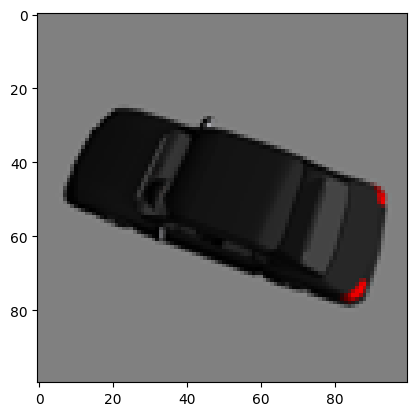

/tmp/ipykernel_1198878/1501450375.py:18: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  pix_idx_rows = pix_idxs // img_size


199
Done!


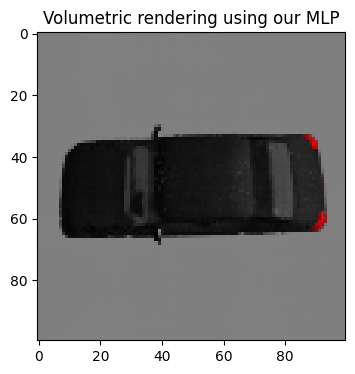

In [17]:
test_idx = 199
plt.imshow(images[test_idx])
plt.show()
test_img = torch.Tensor(images[test_idx]).to(device)
poses = data["poses"]
test_R = torch.Tensor(poses[test_idx, :3, :3]).to(device)
test_ds = torch.einsum("ij,hwj->hwi", test_R, init_ds)
test_os = (test_R @ init_o).expand(test_ds.shape)

# Sample image and associated pose.
# Get rotated ray origins (os) and ray directions (ds). See Section 4.

ds = torch.einsum("ij,hwj->hwi", R, init_ds)
os = (R @ init_o).expand(ds.shape)

# Sample a batch of rays.
pix_idxs = pixel_ps.multinomial(n_batch_pix, False)
pix_idx_rows = pix_idxs // img_size
pix_idx_cols = pix_idxs % img_size
ds_batch = ds[pix_idx_rows, pix_idx_cols].reshape(
    batch_img_size, batch_img_size, -1
)
os_batch = os[pix_idx_rows, pix_idx_cols].reshape(
    batch_img_size, batch_img_size, -1
)

# Run NeRF.

(C_rs_c, C_rs_f) = run_one_iter_of_nerf2(
    ds_batch,
    N_c,
    t_i_c_bin_edges,
    t_i_c_gap,
    os_batch,
    chunk_size,
    F_c,
    N_f,
    t_f,
    F_f,
)

print(test_idx)
target_img = images[test_idx].to(device)

target_img_batch = target_img[pix_idx_rows, pix_idx_cols].reshape(C_rs_f.shape)


F_c.eval()
F_f.eval()
with torch.no_grad():
    (_, C_rs_f) = run_one_iter_of_nerf2(
        test_ds,
        N_c,
        t_i_c_bin_edges,
        t_i_c_gap,
        test_os,
        chunk_size,
        F_c,
        N_f,
        t_f,
        F_f,
    )


plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.imshow(C_rs_f.detach().cpu().numpy())
plt.title("Volumetric rendering using our MLP")

F_c.train()
F_f.train()

print("Done!")

In [19]:
def mse(imageA, imageB):
    # Ensure images are float tensors for accurate computation
    imageA=imageA.to(device)
    imageA = imageA.float()
    imageB = imageB.float()
    
    # Calculate squared difference between images
    squared_diff = (imageA - imageB) ** 2
    
    # Compute mean squared error
    mse_value = torch.mean(squared_diff)
    
    return mse_value.item()  # Convert tensor to float

# Assuming images[test_idx] and C_rs_f are torch tensors
mse_value = mse(mlp_output, function_output)
print("Mean Squared Error:", mse_value*255*255)

Mean Squared Error: 28.792503866861807


In [15]:
print("time for MLP:-",mlp)
print("time for func:-",func)

time for MLP:- 0.13244366645812988
time for func:- 0.39562439918518066


In [ ]:
with torch.no_grad():
        (_, C_rs_f) = run_one_iter_of_nerf(
            test_ds,
            N_c,
            t_i_c_bin_edges,
            t_i_c_gap,
            test_os,
            chunk_size,
            F_c,
            N_f,
            t_f,
            F_f,
        )
        plt.figure(figsize=(10, 4))
        plt.subplot(122)
        plt.title("With using MLP for Volumetric rendering")
        plt.imshow(C_rs_f.detach().cpu().numpy())

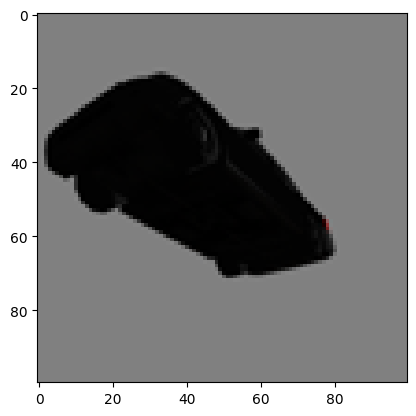

/tmp/ipykernel_1122737/1646324018.py:17: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  pix_idx_rows = pix_idxs // img_size
/tmp/ipykernel_1122737/1073192990.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_color=torch.tensor(X_color)


587
Done!


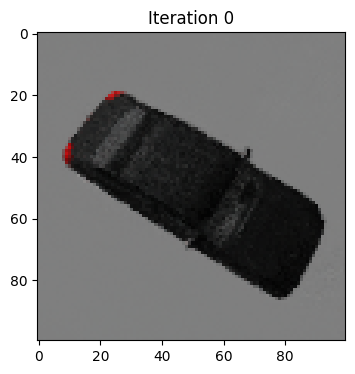

In [134]:
test_idx = 587
plt.imshow(images[test_idx])
plt.show()
test_img = torch.Tensor(images[test_idx]).to(device)
poses = data["poses"]
test_R = torch.Tensor(poses[test_idx, :3, :3]).to(device)
test_ds = torch.einsum("ij,hwj->hwi", test_R, init_ds)
test_os = (test_R @ init_o).expand(test_ds.shape)

# Sample image and associated pose.
# Get rotated ray origins (os) and ray directions (ds). See Section 4.
ds = torch.einsum("ij,hwj->hwi", R, init_ds)
os = (R @ init_o).expand(ds.shape)

# Sample a batch of rays.
pix_idxs = pixel_ps.multinomial(n_batch_pix, False)
pix_idx_rows = pix_idxs // img_size
pix_idx_cols = pix_idxs % img_size
ds_batch = ds[pix_idx_rows, pix_idx_cols].reshape(
    batch_img_size, batch_img_size, -1
)
os_batch = os[pix_idx_rows, pix_idx_cols].reshape(
    batch_img_size, batch_img_size, -1
)

# Run NeRF.

(C_rs_c, C_rs_f) = run_one_iter_of_nerf(
    ds_batch,
    N_c,
    t_i_c_bin_edges,
    t_i_c_gap,
    os_batch,
    chunk_size,
    F_c,
    N_f,
    t_f,
    F_f,
)
# print("C_rs_c: ",C_rs_c.shape)
# print("C_rs_f : ",C_rs_f.shape)
print(test_idx)
target_img = images[test_idx].to(device)
# print(target_img[50][50])
target_img_batch = target_img[pix_idx_rows, pix_idx_cols].reshape(C_rs_f.shape)


F_c.eval()
F_f.eval()
with torch.no_grad():
    (_, C_rs_f) = run_one_iter_of_nerf(
        test_ds,
        N_c,
        t_i_c_bin_edges,
        t_i_c_gap,
        test_os,
        chunk_size,
        F_c,
        N_f,
        t_f,
        F_f,
    )


plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.imshow(C_rs_f.detach().cpu().numpy())
plt.title(f"Iteration {i}")
# plt.subplot(122)
# plt.plot(iternums, psnrs)
# plt.title("PSNR")
# plt.show()
F_c.train()
F_f.train()

print("Done!")